In [1]:
from si import *

Not a jupyter notebook. Not enabling notebook functions.
Welcome to JupyROOT 6.20/04
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


# Slow term search using KS statistic on energy spectrum

### Goal: look at the energy spectrum very late in the fill, compare with rolling omega_a period, see if we can see anything strange

---


In [2]:
f = r.TFile("./data/run2c_pileup_corrected_non.root")
f.cd("clustersAndCoincidences")
f.ls()

TFile**		./data/run2c_pileup_corrected_non.root	
 TFile*		./data/run2c_pileup_corrected_non.root	
  TDirectoryFile*		clustersAndCoincidences	clustersAndCoincidences
   KEY: TH3D	uncorrected;1	uncorrected
   KEY: TH3D	corrected;1	corrected
   KEY: TH2I	triples;1	triples
   KEY: TH2I	quadruples;1	quadruples
   KEY: TH1I	ctag;1	ctag
  KEY: TDirectoryFile	clustersAndCoincidences;1	clustersAndCoincidences


In [3]:
h = f.Get("clustersAndCoincidences/corrected").Clone()

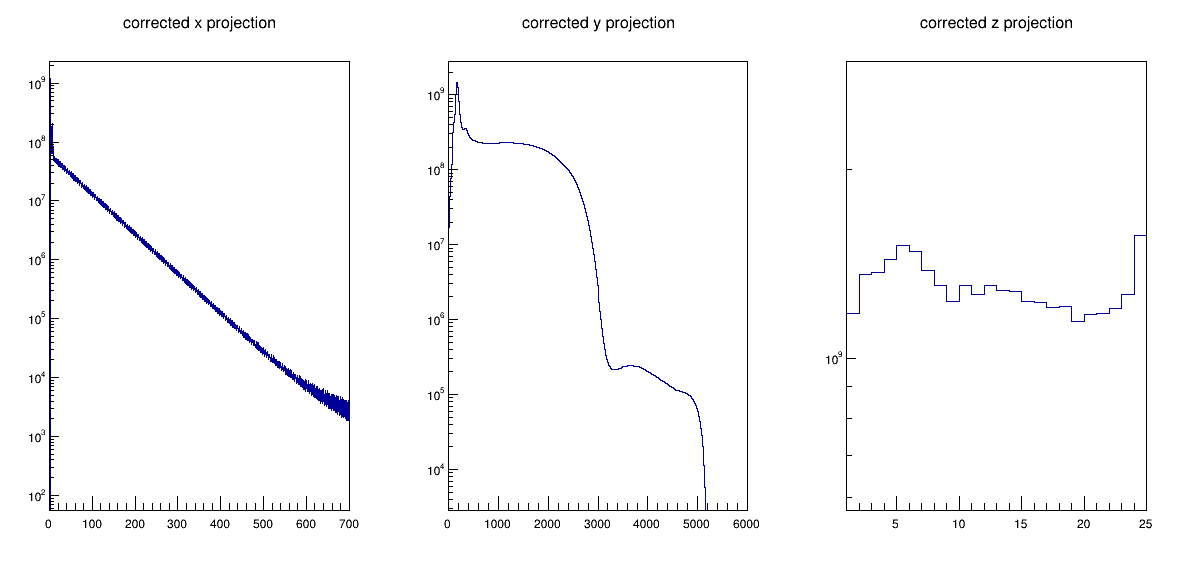

In [4]:
c = r.TCanvas("c","c",1200,600)
c.Divide(3)
for i,xi in enumerate(['x','y','z']):
    c.cd(i+1)
    h.Project3D(xi).Draw()
    r.gPad.SetLogy()
c.Draw()

In [5]:
omega_a_period = 4.37 # microseconds

In [6]:
width = h.GetXaxis().GetBinWidth(10)
print(width)
print(omega_a_period/width)
print(width*29)

0.14919011082693948
29.291485714285713
4.3265132139812446


### We only care about things which make it into our omega_a fits, so we can ignore everything below a certain energy

In [7]:
eLow = 1000
eHigh = 3100

tlow = 25
thigh = 400

In [8]:
h.GetYaxis().SetRangeUser(eLow,eHigh)

### Lets get our reference spectrum

In [9]:
nperiods = 50
thigh1 = 400
thigh2 = thigh1 + nperiods * omega_a_period
print(thigh1, thigh2)
# thigh2 = 700 #change to N exact g-2 periods

h.GetXaxis().SetRangeUser(thigh1, thigh2)

ref_spectrum = h.Project3D("y").Clone("ref_spectrum")
ref_spectrum.Scale(1/ref_spectrum.Integral())

400 618.5


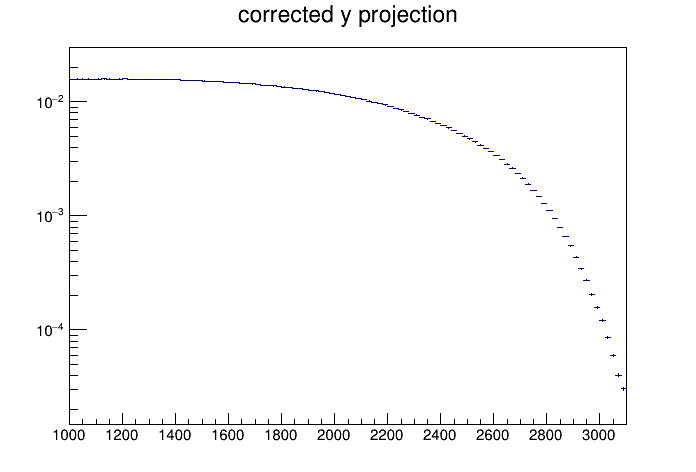

In [10]:
c = r.TCanvas()
ref_spectrum.Draw()
c.SetLogy()
c.Draw()

In [11]:
samp = []
for i in range(100000):
    samp.append(ref_spectrum.GetRandom())

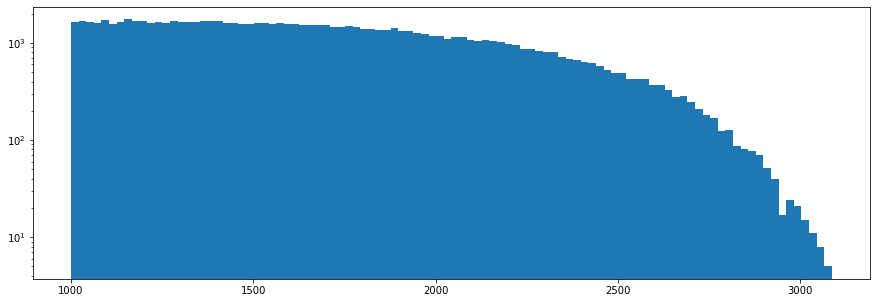

In [12]:
fig,ax = plt.subplots(figsize=(15,5))
plt.hist(samp,bins=100)
plt.yscale("log")
plt.show()

In [13]:
fa = r.TF1("fa", "[0]*(1 + [1]*TMath::Cos([2]*x + [3]))",0,700,4)
fa.SetParameters(.001, 0.33333, 0.23*math.pi*2, 0)
fa.SetNpx(2000)

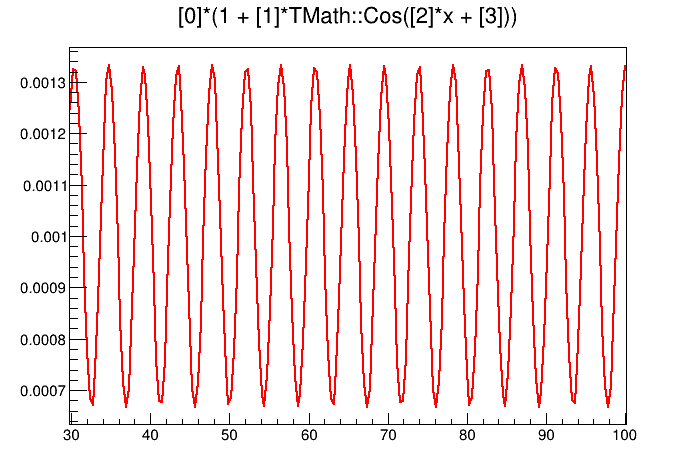

In [14]:
c = r.TCanvas()
fa.Draw()
fa.GetXaxis().SetRangeUser(30,100)
c.Draw()

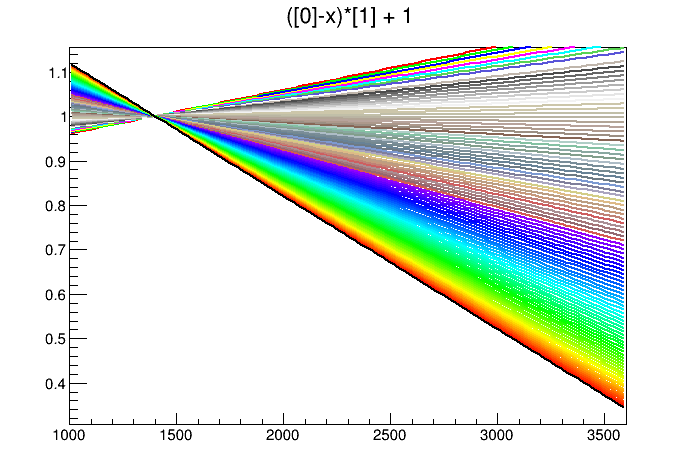

In [15]:
fscale = r.TF1("fscale","([0]-x)*[1] + 1",1000,3600,2)
fscale.SetParameters(1500,1-fa.Eval(40))
fscale.Draw()
for i in range(1,100):
    fscale.SetParameters(1400,.001-fa.Eval(40+i/100.))
    fscale.SetLineColor(i+1)
    fscale.DrawCopy("same")
c.Draw()

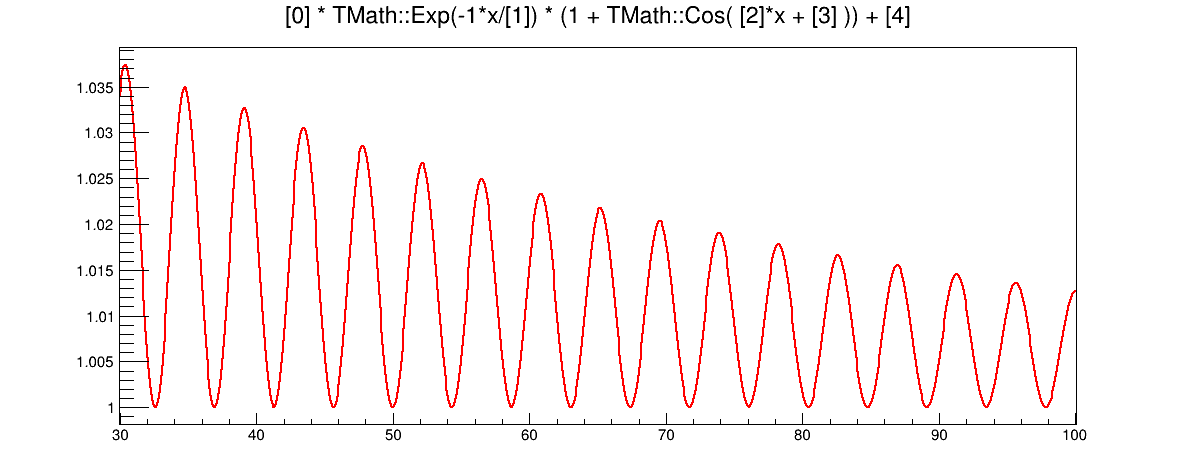

In [16]:
fgain = r.TF1("fgain", "[0] * TMath::Exp(-1*x/[1]) * (1 + TMath::Cos( [2]*x + [3] )) + [4]",0,700,5)
fgain.SetParameters(0.03, 64.4, 0.23*math.pi*2, 0, 1)
fgain.SetNpx(10000)
c = r.TCanvas("c","C",1200,500)
fgain.Draw()
fgain.GetXaxis().SetRangeUser(30,100)
c.Draw()

In [17]:
npoints = 1000
nsamples = 5000000

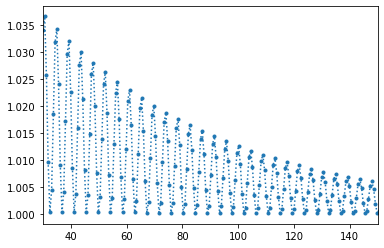

In [18]:
# factors = np.linspace(initialScaleFactor, finalScaleFactor,npoints)
factors = []
times = []
for i in np.linspace(30,650,npoints):
    factors.append(fgain.Eval(i))
    times.append(i)

plt.plot(times,factors,".:")
plt.xlim(30,150)
plt.show()

In [19]:
%%time

hists = []
# hists_py = []

h_ref = r.TH1F("h_ref", "Reference Hist", 100,2000,3100)

for j, scalefactor in enumerate(factors):
    if(j % 100 == 0):
        print(j, scalefactor)
    hi = h_ref.Clone("h_"+str(scalefactor))
    hi.Reset()
    sampi = []
    fscale.SetParameters(1400,.001-fa.Eval(times[j]))
    for i in range(nsamples):
        thissamp = ref_spectrum.GetRandom()*scalefactor
#         hists_py.append(thissamp)
        hi.Fill(thissamp)
    for bini in range(1, hi.GetNbinsX()+1):
        omega_a_osc_factor = fscale.Eval( hi.GetBinCenter(bini) )
        hi.SetBinContent(bini, hi.GetBinContent(bini)*omega_a_osc_factor )
        
    hists.append((scalefactor, hi.Clone("h_"+str(scalefactor))))
#     break
# print(hists)

0 1.034060640260024
100 1.0104725887634551
200 1.000141936241391
300 1.0008676412661448
400 1.0007974281189538
500 1.0001317495267479
600 1.0000023702325131
700 1.000031551999835
800 1.0000154531239736
900 1.0000010389288199
CPU times: user 1h 35min 26s, sys: 15min 22s, total: 1h 50min 48s
Wall time: 1h 49min 50s


In [20]:
hists[0][1]

<ROOT.TH1F object ("h_1.034060640260024") at 0x559eaa892910>

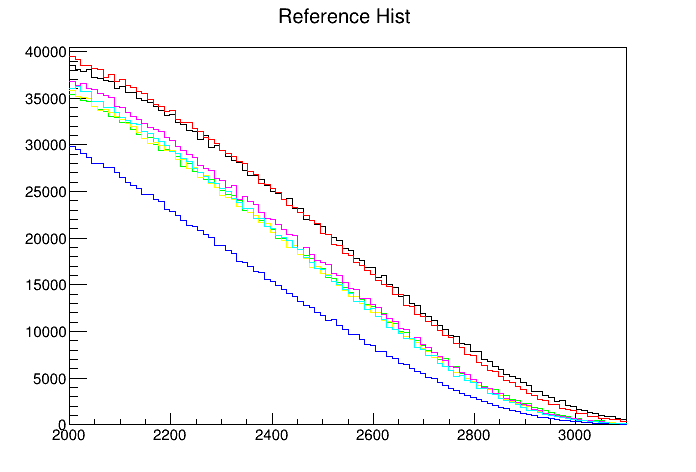

In [21]:
thesehists = [0,50,100,150,170,210,345]
c = r.TCanvas()
for i, hnumi in enumerate(thesehists):
    try:
        hi = hists[hnumi][1]
    except:
        break
    hi.SetLineColor(i+1)
    if(i < 1):
        hi.Draw()
    else:
        hi.Draw("SAME")
#     break
c.Draw()

In [22]:
ks = []

h_ref = hists[len(hists)-1][1]

for i,(scale, hi) in enumerate(hists):
    if(i % 100 == 0):
        print(i, scale)
#     ksi = 0# h_ref.Chi2Test(hi,"UU NORM CHI2/NDF")
    ksi = h_ref.Chi2Test(hi,"UU NORM CHI2/NDF")
    ks.append(ksi)

0 1.034060640260024
100 1.0104725887634551
200 1.000141936241391
300 1.0008676412661448
400 1.0007974281189538
500 1.0001317495267479
600 1.0000023702325131
700 1.000031551999835
800 1.0000154531239736
900 1.0000010389288199


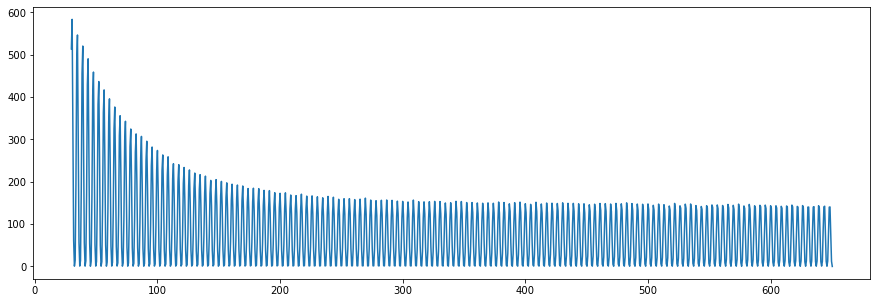

In [23]:
fig,ax = plt.subplots(figsize=(15,5))
plt.plot(times, ks)
plt.show()

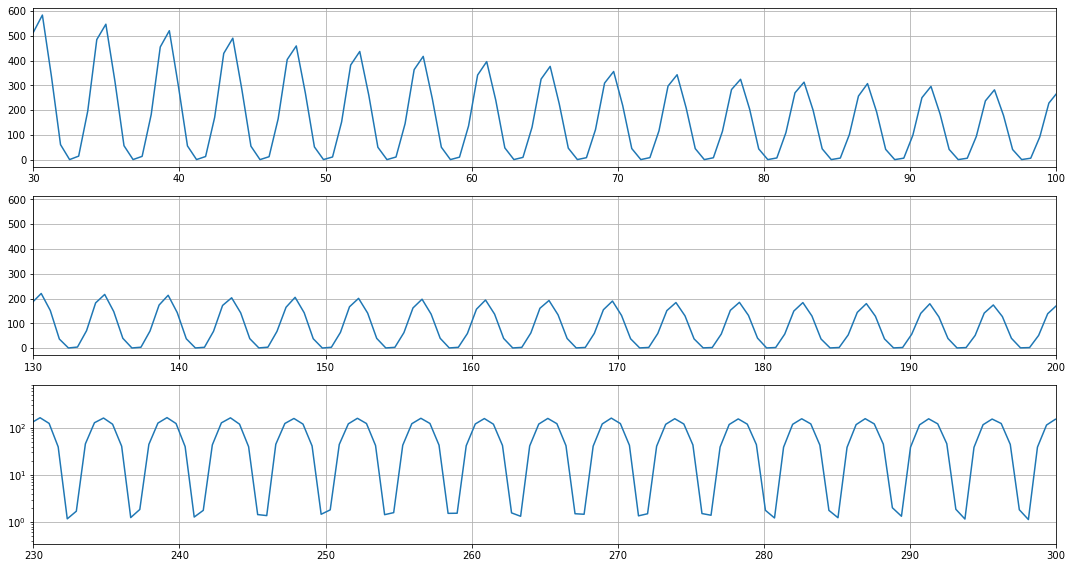

In [24]:
fig,ax = plt.subplots(3,1,figsize=(15,8))
for i,axi in enumerate(ax):
    axi.plot(times,ks)
    axi.set_xlim(30+(100*i),100+(100*i))
    axi.grid()
plt.yscale("log")
plt.tight_layout()
plt.show()

In [25]:
df = pandas.DataFrame([x for x in zip(times,ks)],columns=['time', 'chisquare'])
df.to_csv("./data/monte_carlo_chiSquare_omegaA_"+str(npoints)+"_points_"+str(nsamples)+"_samples.csv", sep="|")